The following notebook tests the model/samplers ability to identify the correlation between the two responses in a regression setting. The model for the data is
$$
    ( z_{i,1}, z_{i,2}) = \big(h_1(x_{i,1}), h_2(x_{i,2})\big) + \epsilon_{i}^\top
$$
where $h_1(x) = \sin(10\pi x),$ $h_2(x) = \frac{1}{4}(\phi(x; 0.15, 0.05^2) + \phi(x; 0.6, 0.2^2))$ and $\epsilon_i \sim \mathcal{N}\big((0,0), (1\ \rho; \rho\ 1)\big)$, independently for each $i$. As data-generating distribution for the covariates, we take $x_{j,i}\sim \mathcal{U}(0,1)$ independently for all $i$ and $j$, and the observed data is generated through $y_{i,j} = F^{-1}(\Phi(z_{i,j}))$, where $F$ is the cdf of the $\Gamma(3,2)$-distribution.

We model the effects of $x_{i,1}$ and $x_{i,2} on each of the response variables with a cubic B-spline basis, each basis of dimension 25, leading to a total of $100$ regression coefficients.

For the correlation parameter, we use the uniform prior $\rho \sim \mathcal{U}(-1, 1)$. 

To investiage the performance of the sampler, we consider three different sample sizes $n = 100$, $n = 1000$ and $n = 5000$. We start by setting up the problem:

In [1]:
# Load required packages
using Random, Distributions, StatsPlots, AdvancedHMC, LogDensityProblems, MCMCChains, LinearAlgebra, AbstractMCMC
include(joinpath(@__DIR__, "..", "src", "ImplicitSVARCop.jl"))
using .ImplicitSVARCop

In [2]:
# Functions used to generate data:
h1(x) = sin(10.0*pi*x)
h2(x) = 0.25 * ( pdf(Normal(0.15, 0.05), x) + pdf(Normal(0.6, 0.2), x) )

h_bivariate(x) = hcat(h1.(x[:,1]), h2.(x[:,2]))

# Function to simulate from the data-generating process as given above.
function simulate_scenario_4(rng::Random.AbstractRNG, n_sim::Int; corr)
    r2 = 0.47
    r3 = 0.58

    D = Diagonal([r2, r3])
    R = [1.0 corr; corr 1.0]
    V_ϵ = Symmetric(D * R * D)
    ϵ = transpose(rand(rng, MvNormal(zeros(2), V_ϵ), n_sim))
    
    # Simulate covariates
    x = rand(rng, Uniform(), (n_sim, 2)) # nonlinear effect

    # Copula scale:
    z = h_bivariate(x) + ϵ
    u = cdf(Normal(), z)
    y = quantile(Gamma(3, 2), u)
    return x, y
end

simulate_scenario_4 (generic function with 1 method)

Having set up the test problem, we run the experiment as indicated. We report posterior means, medians and plot a kernel estimate of the posterior density of the correlation parameter $\rho$, estimated from the MCMC samples. In addition, we run Variational inference on the same datasets for comparison later.

In [3]:
function run_example_bivariate(n::Int)
    rng = Random.Xoshiro(1)

    # Simulate the data:
    corr = 0.5
    x, y = simulate_scenario_4(rng, n; corr=corr)

    order = 4
    dim_basis = 25
    F = hcat(
        B_spline_basis_matrix(x[:,1], order, dim_basis),
        B_spline_basis_matrix(x[:,2], order, dim_basis)
    )

    # Estimate marginal density and transform data to latent scale:
    My = copy(y)
    Mz_est, kdests = fit_marginals(My, SSVKernel()) # Fit kernel estimates to each marginal using the Shimazaki-Shinmoto adaptive kernel estimator.
    z_est = vec(Mz_est)

    # Create VARModel object:
    K = 2
    J = K*dim_basis
    M = 1
    df_ξ = 1.0
    model = VARModel(z_est, F, K, J, M, n; df_ξ=df_ξ)

    # Number of samples, adaptation steps
    n_samples, n_adapts = 10_000, 2_000

    D = 2*K*J+K+1
    θ_init = rand(rng, Normal(), D)

    # Specify which samplers to use for ξ and ρ in unconstrained space
    sampler_ξ = NUTS(0.75)
    sampler_ρ = NUTS(0.75)

    # Run the NUTS sampler
    samples = composite_gibbs_abstractmcmc_lkj(rng, model, sampler_ξ, sampler_ρ, θ_init, n_samples; n_adapts=n_adapts, progress=true)

    # Adaptation steps are treated as burn-in and are subsequently discarded
    chain = MCMCChains.Chains(samples[n_adapts:end])
    samp_ρ = tanh.(vec(chain[:param_203].data))  # The correlation parameter is sampled in an unconstrained space via, i.e. the sampler is targetting atanth(ρ).

    # Run variational inference
    viposterior, ELBOs = fitBayesianSVARCopVI_lkj(rng, model, 5000, 5) # Dimension of B is dim × 5. To fit the model, we use 5000 SGA iterations
    return samp_ρ, viposterior
end

run_example_bivariate (generic function with 1 method)

In [4]:
# Run the MCMC algorithm and variational inference (takes about 15 mins to run on my machine)
samples_ρ = Vector{Float64}[]
viposteriors = []
sample_sizes = [100, 400, 1500, 5000]
for n in sample_sizes
    mcmc, viposterior = run_example_bivariate(n)
    push!(samples_ρ, mcmc)
    push!(viposteriors, viposterior)
end

┌ Info: Found initial step size 0.05
└ @ AdvancedHMC C:\Users\yr4426\.julia\packages\AdvancedHMC\5UkSY\src\abstractmcmc.jl:340
┌ Info: Found initial step size 0.025
└ @ AdvancedHMC C:\Users\yr4426\.julia\packages\AdvancedHMC\5UkSY\src\abstractmcmc.jl:340
Generating samples 100%|███████████████████████████████| Time: 0:00:20
Optimizing ELBO  18%|██████                         |  ETA: 0:00:00
Optimizing ELBO  41%|█████████████                  |  ETA: 0:00:00
Optimizing ELBO  64%|████████████████████           |  ETA: 0:00:00
Optimizing ELBO  87%|███████████████████████████    |  ETA: 0:00:00
Optimizing ELBO 100%|███████████████████████████████| Time: 0:00:00
   ELBO: 27.89472296564074
┌ Info: Found initial step size 0.025
└ @ AdvancedHMC C:\Users\yr4426\.julia\packages\AdvancedHMC\5UkSY\src\abstractmcmc.jl:340
┌ Info: Found initial step size 0.025
└ @ AdvancedHMC C:\Users\yr4426\.julia\packages\AdvancedHMC\5UkSY\src\abstractmcmc.jl:340
Generating samples 100%|███████████████████████████

In [5]:
# Get posterior means, medians:
stats_mcmc = Matrix{Any}(undef, length(sample_sizes)+1, 4)
stats_vi = Matrix{Any}(undef, length(sample_sizes)+1, 4)
stats_mcmc[1,:] = [:N, :mean_ρ, :median_ρ, :std_ρ]
stats_vi[1,:] = [:N, :mean_ρ, :median_ρ, :std_ρ]
for i in eachindex(samples_ρ)
    # MCMC
    stats_mcmc[i+1,:] .= [sample_sizes[i], mean(samples_ρ[i]), median(samples_ρ[i]), std(samples_ρ[i])]

    # VI
    # To get means, medians and standard deviations of the transformed parameter we just use Monte Carlo simulations for simplicity. (Numeric quadrature is also possible)
    ρ_vi = tanh.(rand(viposteriors[i], 1000)[end,:])
    stats_vi[i+1,:] .= [sample_sizes[i], mean(ρ_vi), median(ρ_vi), std(ρ_vi)]
end

# Plot KDE of posterior distribution
p1 = plot(xlims = [0.2, 0.8], xlabel = "ρ", ylabel="Density")
for i in eachindex(samples_ρ)
    density!(p1, samples_ρ[i], label="n = $(sample_sizes[i])")
end
vline!(p1, [0.5], color=:purple, linestyle=:dot, label="True value")
nothing

In [6]:
display(stats_mcmc)

5×4 Matrix{Any}:
     :N   :mean_ρ   :median_ρ   :std_ρ
  100.0  0.471105  0.478859    0.10901
  400.0  0.515336  0.517443    0.0431941
 1500.0  0.498795  0.498704    0.0197665
 5000.0  0.494221  0.494494    0.0107955

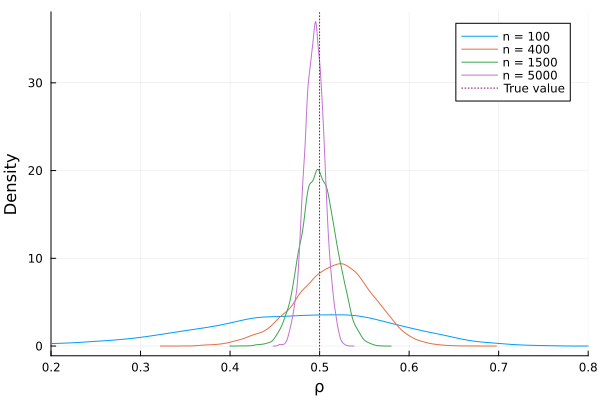

In [7]:
p1

In this example the posterior becomes incerasingly concentrated on the true value of $\rho$ as the number of samples grows, as can be seen from the decay of the standard deviation and the increased concentration of the posterior density as the sample size grows. You can also try running the code with different values of the true correlation parameter.

For comparison, we also include the variational posterior of $\rho$. In the variational approximation, we construct an approximate multivariate normal approximation to the joint posterior of the unconstrained parameter vector, so the marginal posterior of $\mathrm{tanh}^{-1}(\rho)$ is normal. The Jacobian of the map $x \mapsto \mathrm{tanh}(x)$ is $1/(1-x^2)$, so the variational marginal posterior pdf of $\rho$ is $\phi(\tanh^{-1}(\rho);\mu, \sigma^2)/(1-\rho^2)$. In the panel below, we plot the variational posteriors together with the corresponding mcmc sample:

In [8]:
ps = []
xlims_ps = [[-0.1, 1.1], [0.3, 0.8], [0.40, 0.60], [0.45, 0.55]]
t = LinRange(-1+1e-10, 1-1e-10, 1001)
for i in eachindex(sample_sizes)
    viposterior = viposteriors[i]
    μ = viposterior.μ[203]
    σ = sqrt(cov(viposterior)[203, 203])

    pl = plot(xlabel="ρ", title="n = $(sample_sizes[i])", xlims=xlims_ps[i], legend=false)
    density!(pl, samples_ρ[i], label="")
    plot!(pl, t, pdf.(Normal(μ, σ), atanh.(t))./(1 .- abs2.(t)), label="")
    vline!(pl, [0.5], color=:purple, linestyle=:dot, label="")
    push!(ps, pl)
end


plegend = plot([0.0, 1.0], [0,0], lims=(0,1), legendfontsize=15, legend=:outerleft,
        fg_color_legend = nothing, label="MCMC", frame=:none, legendlinewidth=3)
plot!([0.0, 1.0], [0,0], label = "VI")
plot!([0.0, 1.0], [0,0], label = "True value", color=:purple, linestyle=:dash)
nothing

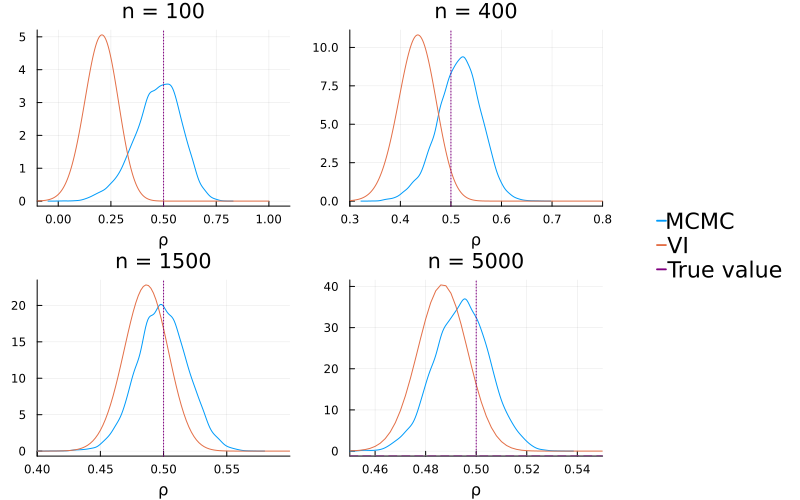

In [9]:
layout = @layout [grid(2,2) a{0.19w}]
p = plot(ps[1], ps[2], ps[3], ps[4], plegend, 
    layout = layout, size=(800,500))

In [10]:
display(stats_mcmc)
display(stats_vi)

5×4 Matrix{Any}:
     :N   :mean_ρ   :median_ρ   :std_ρ
  100.0  0.471105  0.478859    0.10901
  400.0  0.515336  0.517443    0.0431941
 1500.0  0.498795  0.498704    0.0197665
 5000.0  0.494221  0.494494    0.0107955

5×4 Matrix{Any}:
     :N   :mean_ρ   :median_ρ   :std_ρ
  100.0  0.1998    0.200986    0.0796009
  400.0  0.431232  0.432369    0.0373264
 1500.0  0.485775  0.48563     0.0177539
 5000.0  0.486734  0.487187    0.00942615

The results from MCCMC indicate that the variational approximation to the posterior is very poor for $n = 100$, where the posterior mean of the parameter is severely underestimated. The inference for the mean and the median improves with the sample size, but it remains less accurate than that from MCMC. At all sample sizes, the posterior uncertainty is underestimated as indicated by the smaller estimated standard deviations.